### 2.1 Task 1
Implement the MLP architecture by completing the files mlp numpy.py and modules.py.

In [164]:
import numpy as np

class Linear(object):
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.cache = None
        self.params['weight'] = np.random.normal(loc=0.0, scale = 0.5, size = (in_features,out_features))
        self.params['bias'] = np.zeros((1,out_features))
        self.grads = {'weight': None, 'bias': None}

    def forward(self, x):
        print('Linear forward:', x.shape, self.params['weight'].shape, self.params['bias'].shape)
        self.cache = x
        output = x @ self.params['weight'] + self.params['bias']
        return output

    def backward(self, dout):
        x = self.cache
        self.grads['weight'] = x.T @ dout
        self.grads['bias'] = np.sum(dout, axis=0)
        dx = dout @ self.params['weight'].T
        return dx
        
class ReLU(object):
    def __init__(self):
        self.cache = None

    def forward(self, x):
        self.cache = x
        return np.maximum(0, x)

    def backward(self, dout):
        dx = dout.copy()
        dx[self.cache <= 0] = 0
        return dx

class SoftMax(object):
    def __init__(self):
        self.cache = None
        
    def forward(self, x):
        shifted_x = x - np.max(x, axis=1, keepdims=True)  # 数值稳定性
        exp_x = np.exp(shifted_x)
        probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        self.cache = probs
        return probs

    def backward(self, dout):
        return dout

class CrossEntropy(object):
    def __init__(self):
        self.cache = None

    def forward(self, x, y):
        N = x.shape[0]
        # --- 手动实现数值稳定性 ---
        max_x = np.max(x, axis=1)
        max_x_reshaped = max_x.reshape(-1, 1)
        exp_x = np.exp(x - max_x_reshaped)
        sum_exp_x = np.sum(exp_x, axis=1)
        sum_exp_x_reshaped = sum_exp_x.reshape(-1, 1)
        probs = exp_x / sum_exp_x_reshaped
        self.cache = probs
        
        # 计算交叉熵损失
        log_probs = np.log(probs[range(N), y] + 1e-12)  # 添加小量防止log(0)
        loss = -np.mean(log_probs)
        
        return loss

    def backward(self, x, y):
        N = x.shape[0]
        probs = self.cache
        dx = probs.copy()
        dx[range(N), y] -= 1
        dx /= N
        return dx

In [165]:

class MLP(object):
    def __init__(self, n_inputs, n_hidden, n_classes):
        dims = [n_inputs] + n_hidden + [n_classes]
        self.layers = []
        for i in range(len(dims) - 1):
            self.layers.append(Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                self.layers.append(ReLU())
        
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer.forward(out)
        return out

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout


### 2.2 Task 2
Implement training and testing script in train mlp numpy.py. (Please keep 80% of the dataset for training and
the remaining 20% for testing. Note that this is a random split of 80% and 20% )

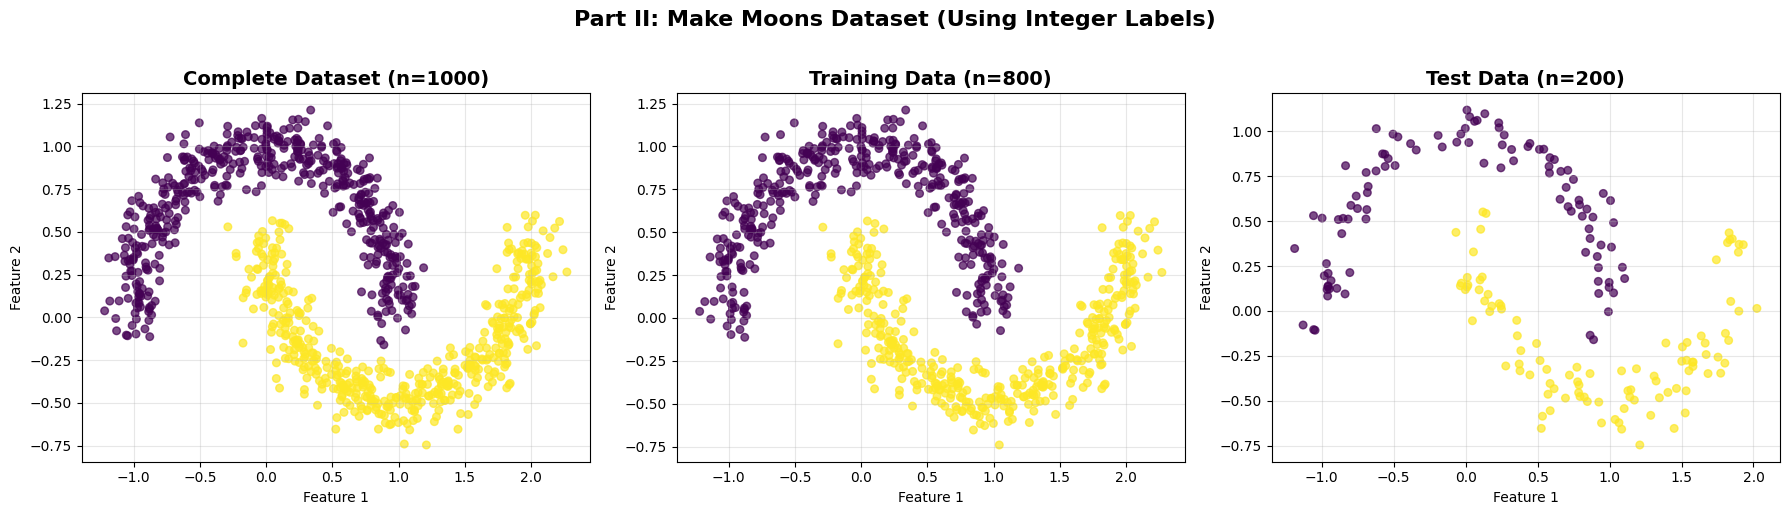

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

sample = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=42)
data = sample[0]
label = sample[1]

train_X = np.mat(data[0:800])
train_y = label[0:800].astype(int)  # <--- 确保是整数类型
test_X = np.mat(data[800:])
test_y = label[800:].astype(int)    # <--- 确保是整数类型

# 创建可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Complete dataset
axes[0].scatter(data[:, 0], data[:, 1], c=label, cmap='viridis', alpha=0.7, s=30)
axes[0].set_title('Complete Dataset (n=1000)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].grid(True, alpha=0.3)

# Plot 2: Training data
axes[1].scatter(train_X[:, 0].A1, train_X[:, 1].A1, c=train_y, 
                cmap='viridis', alpha=0.7, s=30)
axes[1].set_title('Training Data (n=800)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].grid(True, alpha=0.3)

# Plot 3: Test data
axes[2].scatter(test_X[:, 0].A1, test_X[:, 1].A1, c=test_y, 
                cmap='viridis', alpha=0.7, s=30)
axes[2].set_title('Test Data (n=200)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Part II: Make Moons Dataset (Using Integer Labels)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 2.3 Task 3
Using the default values of the parameters, report the results of your experiments using a jupyter notebook where
you show the accuracy curves for both training and test data.

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from mlp_numpy import MLP

def accuracy(predictions, targets):
     # 将概率分布转换为预测标签
    predicted_labels = np.argmax(predictions, axis=1)
    result = predicted_labels == targets
    accuracy = np.mean(result)
    return accuracy

def generate_data(num):
    data, label = make_moons(n_samples=num, shuffle=True, noise=0.1, random_state=42)
    
    split_idx = int(num * 0.8)
    
    train_X = data[:split_idx]
    train_y = label[:split_idx].astype(int)
    
    test_X = data[split_idx:]
    test_y = label[split_idx:].astype(int)
    
    return train_X, train_y, test_X, test_y

def train_BGD(dnn_hidden_units, learning_rate, max_steps, eval_freq):
    train_X, train_y, test_X, test_y = generate_data(1000)
    model = MLP(n_inputs=2, n_hidden=dnn_hidden_units, n_classes=2)
    loss_fn = CrossEntropy()

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    num_samples = train_X.shape[0]

    for step in range(max_steps):
        # 1. 前向：全量样本
        scores = model.forward(train_X)
        loss = loss_fn.forward(scores, train_y)

        # 2. 反向：全量梯度
        dout = loss_fn.backward(scores, train_y)
        model.backward(dout)

        # 3. 更新参数
        for layer in model.layers:
            if layer.__class__.__name__ == 'Linear':
                layer.params['weight'] -= learning_rate * layer.grads['weight']
                layer.params['bias'] -= learning_rate * layer.grads['bias']

        # 4. 记录
        history['train_loss'].append(loss)
        if step % eval_freq == 0 or step == max_steps - 1:
            train_acc = accuracy(scores, train_y)
            test_scores = model.forward(test_X)
            test_loss = loss_fn.forward(test_scores, test_y)
            test_acc = accuracy(test_scores, test_y)
            history['train_acc'].append(train_acc)
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            print(f"BGD Step: {step:4d} | Train Loss: {loss:.4f} | "
                  f"Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | "
                  f"Test Acc: {test_acc:.2f}%")
    return history,model


def train_SGD(dnn_hidden_units, learning_rate, max_steps, eval_freq, batch_size=1):
    """
    通用随机（mini-batch）梯度下降
    batch_size=1   -> 纯 SGD
    batch_size=N   -> 批量 BGD
    1<batch_size<N -> Mini-Batch SGD
    """
    train_X, train_y, test_X, test_y = generate_data(1000)
    model = MLP(n_inputs=2, n_hidden=dnn_hidden_units, n_classes=2)
    loss_fn = CrossEntropy()

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    num_samples = train_X.shape[0]

    for step in range(max_steps):
        # 1. 随机抽 batch_size 个样本（真·随机，无替换）
        if batch_size == 1:                 # 纯 SGD：抽 1 个
            idx = np.random.randint(0, num_samples)
            batch_indices = [idx]
        elif batch_size == num_samples:     # 纯 BGD：全量
            batch_indices = np.arange(num_samples)
        else:                               # Mini-Batch：随机无替换采样
            batch_indices = np.random.choice(num_samples, batch_size, replace=False)

        batch_X = train_X[batch_indices]
        batch_y = train_y[batch_indices]

        # 2. 前向 & 计算损失
        scores = model.forward(batch_X)
        loss = loss_fn.forward(scores, batch_y)

        # 3. 反向
        dout = loss_fn.backward(scores, batch_y)
        model.backward(dout)

        # 4. 更新参数
        for layer in model.layers:
            if layer.__class__.__name__ == 'Linear':
                layer.params['weight'] -= learning_rate * layer.grads['weight']
                layer.params['bias'] -= learning_rate * layer.grads['bias']

        # 5. 记录
        history['train_loss'].append(loss)
        if step % eval_freq == 0 or step == max_steps - 1:
            train_scores = model.forward(train_X)
            train_acc = accuracy(train_scores, train_y)
            test_scores = model.forward(test_X)
            test_loss = loss_fn.forward(test_scores, test_y)
            test_acc = accuracy(test_scores, test_y)
            history['train_acc'].append(train_acc)
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            print(f"Step: {step:4d} | Train Loss: {loss:.4f} | "
                  f"Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | "
                  f"Test Acc: {test_acc:.2f}%")
    return history, model

def plot_curves(history, eval_freq, title_suffix=""):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # 绘制损失曲线
    ax1.plot(history['train_loss'], 'b-', linewidth=2, label='Train Loss')
    # 使用传入的 eval_freq 参数
    test_loss_steps = np.arange(0, len(history['test_loss']) * eval_freq, eval_freq)
    ax1.plot(test_loss_steps, history['test_loss'], 'r-o', label='Test Loss')
    ax1.set_title(f'Loss Curves {title_suffix}', fontsize=16)
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # 绘制准确率曲线
    # 使用传入的 eval_freq 参数
    train_acc_steps = np.arange(0, len(history['train_acc']) * eval_freq, eval_freq)
    test_acc_steps = np.arange(0, len(history['test_acc']) * eval_freq, eval_freq)
    ax2.plot(train_acc_steps, history['train_acc'], 'g-', linewidth=2, label='Train Accuracy')
    ax2.plot(test_acc_steps, history['test_acc'], 'm--', linewidth=2, label='Test Accuracy')
    ax2.set_title(f'Accuracy Curves {title_suffix}', fontsize=16)
    ax2.set_xlabel('Step (Epoch)')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()
def plot_decision_boundary(model, title_suffix=""):
# 生成网格
    x_min, x_max = -2, 3
    y_min, y_max = -1.5, 2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                            np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # 模型预测
    probs = model.forward(grid)
    Z = np.argmax(probs, axis=1).reshape(xx.shape)

    # 绘图
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, levels=50, cmap=plt.cm.RdBu, alpha=0.8)
    plt.colorbar(label='predict class')

    # 再画一遍数据点
    train_X, train_y, _, _ = generate_data(1000)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.RdBu, edgecolors='k')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f"Decision Boundary {title_suffix}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()

Initialized MLP with layers:
  Layer 1: Linear(2 -> 64)
    Activation: ReLU
  Layer 2: Linear(64 -> 32)
    Activation: ReLU
  Layer 3: Linear(32 -> 2)
BGD Step:    0 | Train Loss: 1.6757 | Train Acc: 0.62% | Test Loss: 1.4836 | Test Acc: 0.66%
BGD Step:   20 | Train Loss: 0.4282 | Train Acc: 0.79% | Test Loss: 0.4403 | Test Acc: 0.76%
BGD Step:   40 | Train Loss: 0.3213 | Train Acc: 0.85% | Test Loss: 0.3372 | Test Acc: 0.81%
BGD Step:   60 | Train Loss: 0.2841 | Train Acc: 0.87% | Test Loss: 0.3002 | Test Acc: 0.84%
BGD Step:   80 | Train Loss: 0.2635 | Train Acc: 0.88% | Test Loss: 0.2797 | Test Acc: 0.85%
BGD Step:  100 | Train Loss: 0.2490 | Train Acc: 0.89% | Test Loss: 0.2657 | Test Acc: 0.86%
BGD Step:  120 | Train Loss: 0.2375 | Train Acc: 0.89% | Test Loss: 0.2549 | Test Acc: 0.87%
BGD Step:  140 | Train Loss: 0.2278 | Train Acc: 0.89% | Test Loss: 0.2455 | Test Acc: 0.87%
BGD Step:  160 | Train Loss: 0.2193 | Train Acc: 0.89% | Test Loss: 0.2373 | Test Acc: 0.88%
BGD Step: 

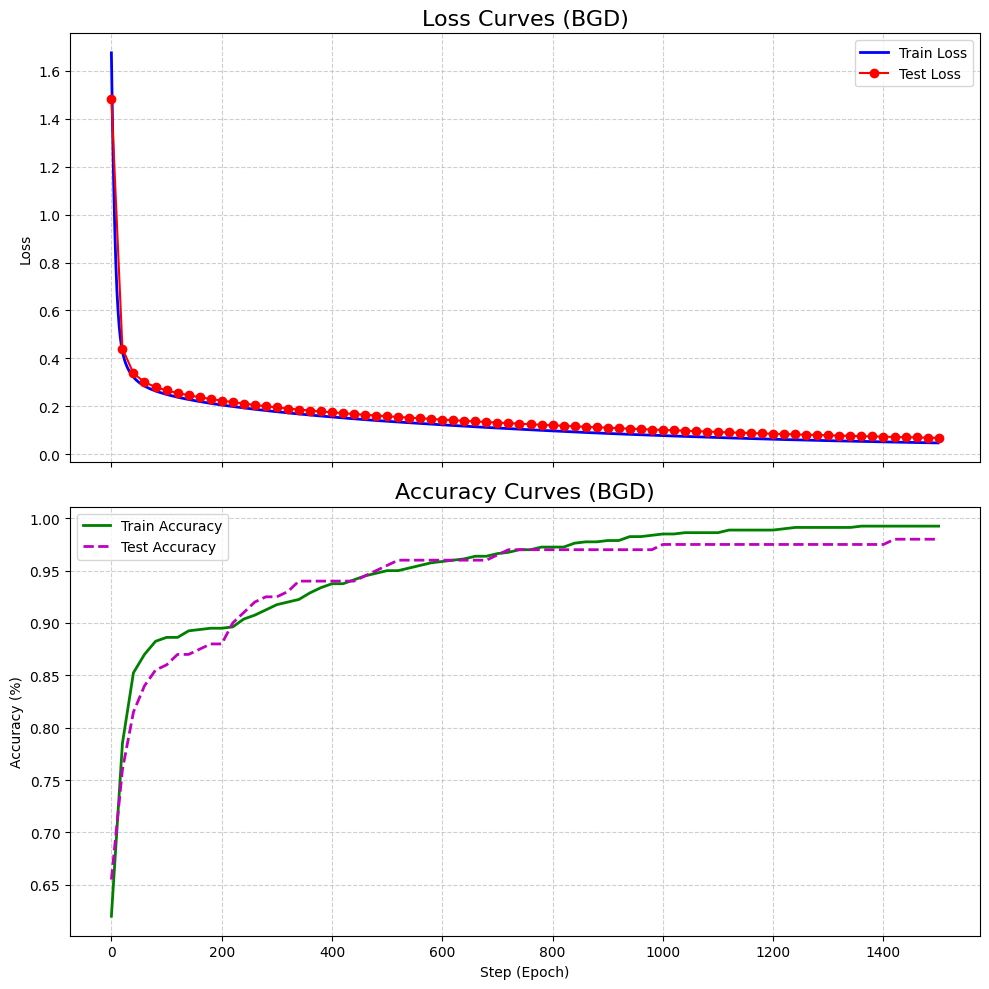

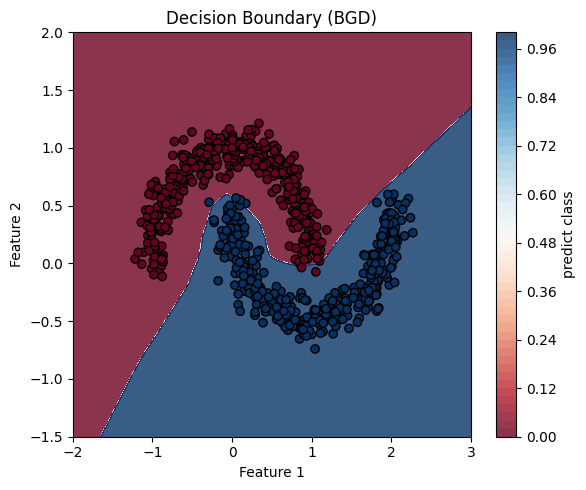

Initialized MLP with layers:
  Layer 1: Linear(2 -> 64)
    Activation: ReLU
  Layer 2: Linear(64 -> 32)
    Activation: ReLU
  Layer 3: Linear(32 -> 2)
Step:    0 | Train Loss: 0.0551 | Train Acc: 0.33% | Test Loss: 2.0331 | Test Acc: 0.30%
Step:   20 | Train Loss: 0.2645 | Train Acc: 0.79% | Test Loss: 0.5475 | Test Acc: 0.72%
Step:   40 | Train Loss: 0.0232 | Train Acc: 0.83% | Test Loss: 0.4298 | Test Acc: 0.81%
Step:   60 | Train Loss: 0.0119 | Train Acc: 0.85% | Test Loss: 0.3559 | Test Acc: 0.84%
Step:   80 | Train Loss: 0.1288 | Train Acc: 0.87% | Test Loss: 0.3081 | Test Acc: 0.85%
Step:  100 | Train Loss: 0.1758 | Train Acc: 0.86% | Test Loss: 0.3183 | Test Acc: 0.85%
Step:  120 | Train Loss: 0.0065 | Train Acc: 0.85% | Test Loss: 0.3488 | Test Acc: 0.88%
Step:  140 | Train Loss: 2.2615 | Train Acc: 0.88% | Test Loss: 0.2740 | Test Acc: 0.86%
Step:  160 | Train Loss: 0.2176 | Train Acc: 0.88% | Test Loss: 0.2663 | Test Acc: 0.88%
Step:  180 | Train Loss: 0.0129 | Train Acc: 0

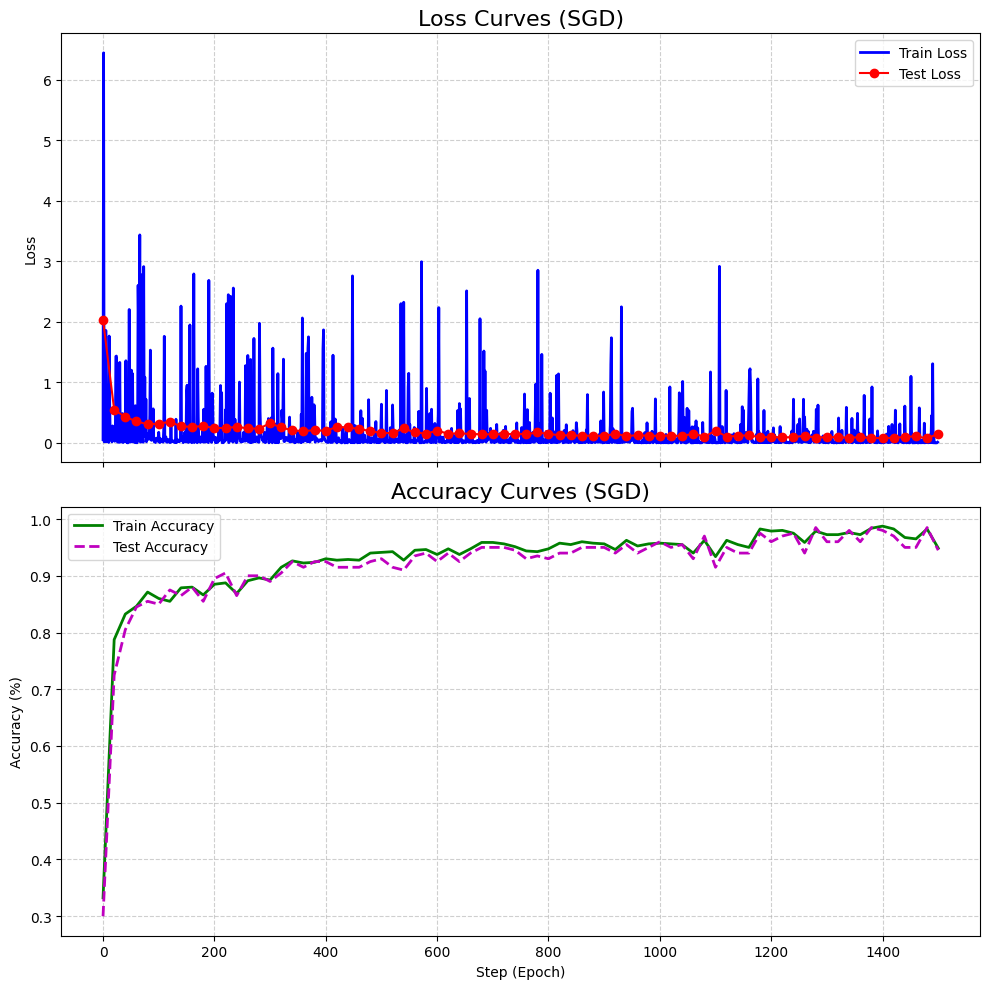

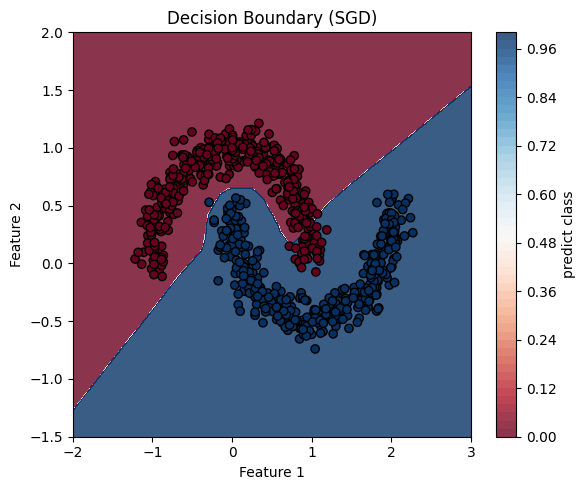

In [174]:
# 设置超参数
HIDDEN_UNITS = [64, 32]  
LEARNING_RATE = 0.01     
MAX_STEPS = 1500      
EVAL_FREQ = 20

# 1. 批量梯度下降
history_bgd,model = train_BGD(HIDDEN_UNITS, LEARNING_RATE, MAX_STEPS, EVAL_FREQ)
plot_curves(history_bgd, EVAL_FREQ, title_suffix="(BGD)")
plot_decision_boundary(model, title_suffix="(BGD)")

history_bgd,model = train_SGD(HIDDEN_UNITS, LEARNING_RATE, MAX_STEPS, EVAL_FREQ, batch_size=1)
plot_curves(history_bgd, EVAL_FREQ, title_suffix="(SGD)")
plot_decision_boundary(model, title_suffix="(SGD)")

In [173]:
def compare_three_views(dnn_hidden_units, learning_rate, max_steps, eval_freq,
                        save_dir="figure", fmt="pdf"):
    """
    生成三张对比大图（2×2 子图）：
      1. Decision Boundary
      2. Train Accuracy
      3. Test Accuracy
    保存为：decision_boundaries.pdf / train_acc.pdf / test_acc.pdf
    """
    import os, time
    os.makedirs(save_dir, exist_ok=True)
    batch_list = [1, 32, 128, 800]
    titles = ["SGD (1)", "Mini-Batch (32)", "Mini-Batch (128)", "BGD (800)"]

    # ---- 预训练，保存历史与模型 ----
    histories, models = [], []
    for bs in batch_list:
        print(f"\n>>> Training batch_size = {bs} ...")
        t0 = time.time()
        hist, model = train_SGD(dnn_hidden_units, learning_rate, max_steps, eval_freq, batch_size=bs)
        histories.append(hist)
        models.append(model)
        print(f"Done in {time.time()-t0:.1f}s")

    # 1. Decision Boundary 大图
    fig1, axes1 = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    axes1 = axes1.flatten()
    for idx, (bs, title) in enumerate(zip(batch_list, titles)):
        ax = axes1[idx]
        model = models[idx]
        xx, yy = np.meshgrid(np.linspace(-2, 3, 400),
                             np.linspace(-1.5, 2, 400))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = np.argmax(model.forward(grid), axis=1).reshape(xx.shape)
        ax.contourf(xx, yy, Z, levels=50, cmap=plt.cm.RdBu, alpha=0.8)
        train_X, train_y, _, _ = generate_data(1000)
        ax.scatter(train_X[:, 0], train_X[:, 1], c=train_y,
                   cmap=plt.cm.RdBu, edgecolors='k', s=10)
        ax.set_title(title)
    fig1.suptitle("Decision Boundaries vs Batch Size", fontsize=14)
    fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig1.savefig(os.path.join(save_dir, f"decision_boundaries.{fmt}"), dpi=300)
    plt.close(fig1)

    # 2. Train Accuracy 大图
    fig2, axes2 = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
    axes2 = axes2.flatten()
    for idx, (bs, title) in enumerate(zip(batch_list, titles)):
        ax = axes2[idx]
        steps = np.arange(len(histories[idx]['train_acc'])) * eval_freq
        ax.plot(steps, histories[idx]['train_acc'], 'b-', linewidth=2)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_title(title)
        ax.set_ylabel("Train Accuracy")
        ax.set_xlabel("Steps")
    fig2.suptitle("Train Accuracy vs Batch Size", fontsize=14)
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2.savefig(os.path.join(save_dir, f"train_acc.{fmt}"), dpi=300)
    plt.close(fig2)

    # 3. Test Accuracy 大图
    fig3, axes3 = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
    axes3 = axes3.flatten()
    for idx, (bs, title) in enumerate(zip(batch_list, titles)):
        ax = axes3[idx]
        steps = np.arange(len(histories[idx]['test_acc'])) * eval_freq
        ax.plot(steps, histories[idx]['test_acc'], 'r-', linewidth=2)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_title(title)
        ax.set_ylabel("Test Accuracy")
        ax.set_xlabel("Steps")
    fig3.suptitle("Test Accuracy vs Batch Size", fontsize=14)
    fig3.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig3.savefig(os.path.join(save_dir, f"test_acc.{fmt}"), dpi=300)
    plt.close(fig3)

    print(f"\n>>> 三张图已保存至 {save_dir}/")
HIDDEN_UNITS = [64, 32]
LEARNING_RATE = 0.01
MAX_STEPS = 1500
EVAL_FREQ = 10

compare_three_views(HIDDEN_UNITS, LEARNING_RATE, MAX_STEPS, EVAL_FREQ,
                save_dir="figure", fmt="png")   # 也可改为 "png"


>>> Training batch_size = 1 ...
Initialized MLP with layers:
  Layer 1: Linear(2 -> 64)
    Activation: ReLU
  Layer 2: Linear(64 -> 32)
    Activation: ReLU
  Layer 3: Linear(32 -> 2)
Step:    0 | Train Loss: 6.1082 | Train Acc: 0.37% | Test Loss: 2.4326 | Test Acc: 0.40%
Step:   10 | Train Loss: 0.0909 | Train Acc: 0.87% | Test Loss: 0.3909 | Test Acc: 0.88%
Step:   20 | Train Loss: 0.2195 | Train Acc: 0.84% | Test Loss: 0.3026 | Test Acc: 0.88%
Step:   30 | Train Loss: 0.0405 | Train Acc: 0.87% | Test Loss: 0.2793 | Test Acc: 0.87%
Step:   40 | Train Loss: 1.9111 | Train Acc: 0.84% | Test Loss: 0.2812 | Test Acc: 0.86%
Step:   50 | Train Loss: 0.2545 | Train Acc: 0.86% | Test Loss: 0.2554 | Test Acc: 0.86%
Step:   60 | Train Loss: 0.1153 | Train Acc: 0.86% | Test Loss: 0.2463 | Test Acc: 0.87%
Step:   70 | Train Loss: 0.1449 | Train Acc: 0.89% | Test Loss: 0.2470 | Test Acc: 0.90%
Step:   80 | Train Loss: 1.7937 | Train Acc: 0.83% | Test Loss: 0.2956 | Test Acc: 0.86%
Step:   90 | 